In [3]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
from scipy.signal import find_peaks
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: /Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis


In [4]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V1')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')


# Cell Fluoresence Retrieval

In [103]:
#script = f'POSIX path of (choose folder default location "{current_directory}")'
#selected_folder = subprocess.check_output(['osascript', '-e', script]).decode('utf-8').strip()
#nd2_files = [f for f in os.listdir(selected_folder) if f.endswith('.nd2')]
#selected_folder = os.path.normpath('D:\Lab Analysis PC\Test Stacks')
#nd2_files = [f for f in os.listdir(os.path.normpath('D:\Lab Analysis PC\Test Stacks')) if f.endswith('.nd2')]

### Model Paths ###
model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V3')
model_path_wga = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_WGA_V2')

all_data = pd.DataFrame()
unid_counter = 0

eGFP_fluorescence_list = []

# FOR TESTING
nd2_files = ['3203R_GLUT1_647_WGA_594_0002.nd2']

for nd2_file in nd2_files:

    # 1) Download Image Data
    print(f'Processing {nd2_file}')
    nd2_path = os.path.join(selected_folder, nd2_file)

    f = nd2.ND2File(nd2_path)
    z_sep = f.voxel_size().z
    image = to_8bit(f.asarray())

    # 2) DAPI max projection, Deblur, Segment
    DAPI_stack = image[:,0,:,:].copy()
    mp_DAPI = max_proj(DAPI_stack)

    # 3) Deblur and Segment DAPI max projection
    deblur_model = denoise.CellposeDenoiseModel(gpu=True, model_type = model_path_dapi, restore_type="deblur_cyto3")
    DAPI_masks, flows, styles, image_deblurred = deblur_model.eval(auto_brightness_contrast(mp_DAPI), diameter=90, channels=[0,0])

    image_deblurred = image_deblurred[:,:,0] # resulting image has one channel, but it still needs to be indexed 

    # DAPI filtering and eGFP identification
    coords_3d = nuclei_centers_of_mass(DAPI_stack, DAPI_masks)
    filtered_coords_3d, filtered_idxs = remove_outliers_local(coords_3d, num_closest_points=15, z_threshold=2)
    filtered_DAPI_masks = extract_masks(DAPI_masks, filtered_idxs)
    DAPI_masks = filtered_DAPI_masks.copy()

    coords_2d = [(i[0], i[1]) for i in filtered_coords_3d]
    in_rip_dict = rip_identifier(nd2_file, image, DAPI_masks, coords_2d)

    '''
    Indiviudal Cell
    '''

    # 5) Segmentation of WGA channel

    mask_idxs = np.delete(np.unique(DAPI_masks), 0) - 1

    for mask_id in mask_idxs:

        
        single_mask = extract_masks(DAPI_masks, mask_id)
        diam = get_mask_diameter(single_mask)
        expansion = 50

        sq_stacks = get_sq_stacks(image, single_mask)
        
        # Running the model of the expanded squares
        expanded_sq_WGA, z_level = extract_square_proj_expand(image, single_mask, expansion)

        model = models.CellposeModel(gpu = True, pretrained_model = model_path_wga)
        expanded_mask, flows, styles = model.eval(expanded_sq_WGA, diameter=diam, channels=[0,0])

        # Removing 0-pixel boundary and finding the largest mask in the array
        WGA_mask = remove_boundary(expanded_mask, expansion)

        if len(np.unique(WGA_mask)) == 1:
            print('No mask found.')
            continue

        # Examine this
        largest_idx = np.argmax(utils.diameters(WGA_mask)[1])
        WGA_mask = extract_masks(WGA_mask, largest_idx)

        # Z-axis profile
        trace_results = get_traces(sq_stacks, WGA_mask)

        # eGFP extraction
        eGFP_sum = np.sum(sq_stacks[1, z_level, :, :][(WGA_mask.astype(bool))])
        eGFP_sum_area_normalized = eGFP_sum / np.sum(WGA_mask)

        eGFP_fluorescence_list.append((mask_id, eGFP_sum_area_normalized))

        '''
        Organizing data
        '''
        
        # 6) Converting trace results into a pd dataframe
        dataframe = organize_data(trace_results, mask_id)

        # 7) Adding file information
        djid, eye, file_base = extract_information(nd2_file)

        nested_array = np.array(range(image.shape[0]))* f.voxel_size().z
        dataframe['X_vals'] = [nested_array for i in range(len(dataframe))]
        dataframe['file_name'] = file_base
        dataframe['DJID'] = djid
        dataframe['Eye'] = eye

        # 8) cell_unid information
        unique_mask_ids = dataframe['mask_id'].unique()
        mask_id_to_unid = {mask_id: unid_counter + i for i, mask_id in enumerate(unique_mask_ids)}
        dataframe['unid'] = dataframe['mask_id'].map(mask_id_to_unid)
        unid_counter += len(unique_mask_ids)

        # Adding in_rip information
        dataframe['in_rip'] = False

        for file_name, mask_ids in in_rip_dict.items():
            dataframe.loc[(dataframe['file_name'] == file_name) & (dataframe['mask_id'].isin(mask_ids)), 'in_rip'] = True

        # 9) Concatenation with existing data
        all_data = pd.concat([all_data, dataframe], ignore_index=True)

Processing 3203R_GLUT1_647_WGA_594_0002.nd2


/var/folders/sl/syqsj8q94yn7kbv8l50mtwdw0000gn/T/ipykernel_49213/2025827368.py:25: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(nd2_path)


No mask found.
No mask found.
No mask found.
No mask found.
No mask found.
No mask found.
No mask found.


(array([86.,  3.,  4.,  3.,  1.,  2.,  2.,  4.,  2.,  3.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 2.35666667,  6.40807797, 10.45948927, 14.51090056, 18.56231186,
        22.61372316, 26.66513446, 30.71654576, 34.76795706, 38.81936836,
        42.87077966, 46.92219096, 50.97360226, 55.02501356, 59.07642486,
        63.12783615, 67.17924745, 71.23065875, 75.28207005, 79.33348135,
        83.38489265]),
 <BarContainer object of 20 artists>)

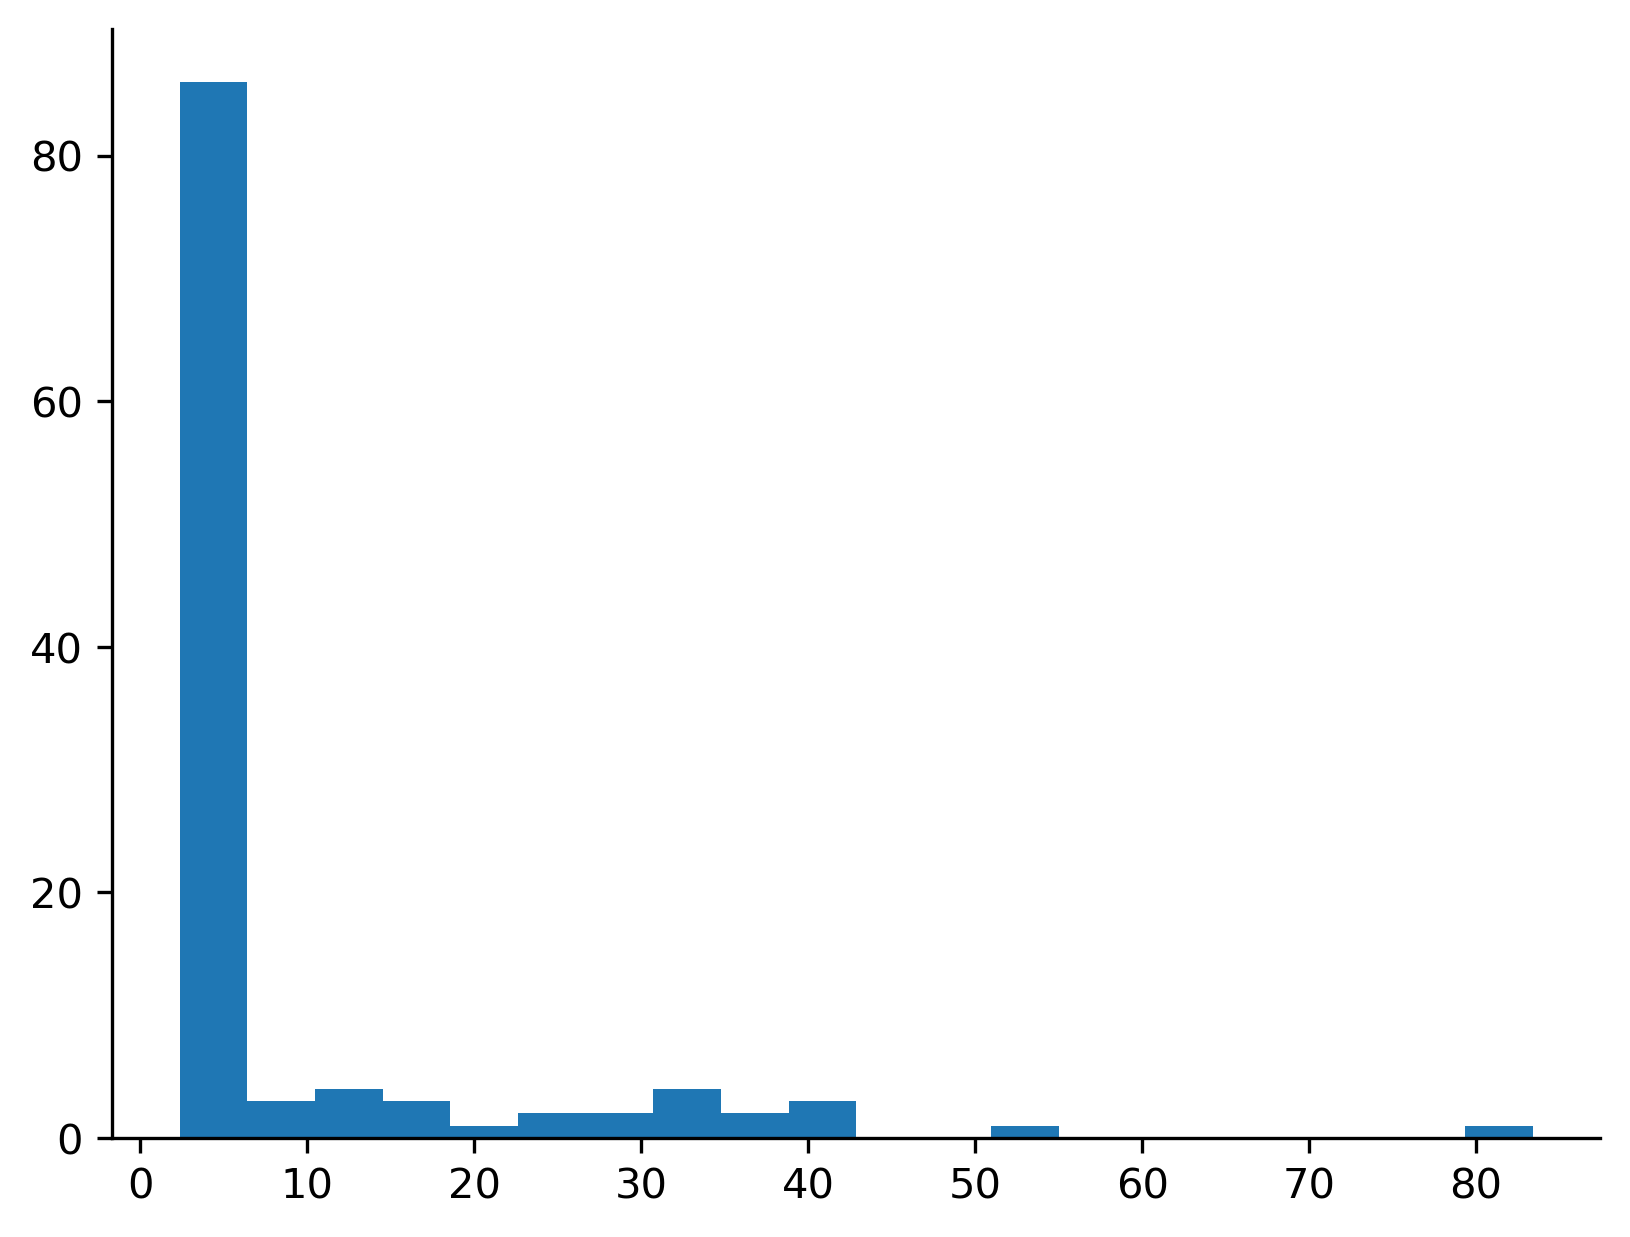

In [80]:
plt.hist(eGFP_fluorescence_list, bins = 20)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

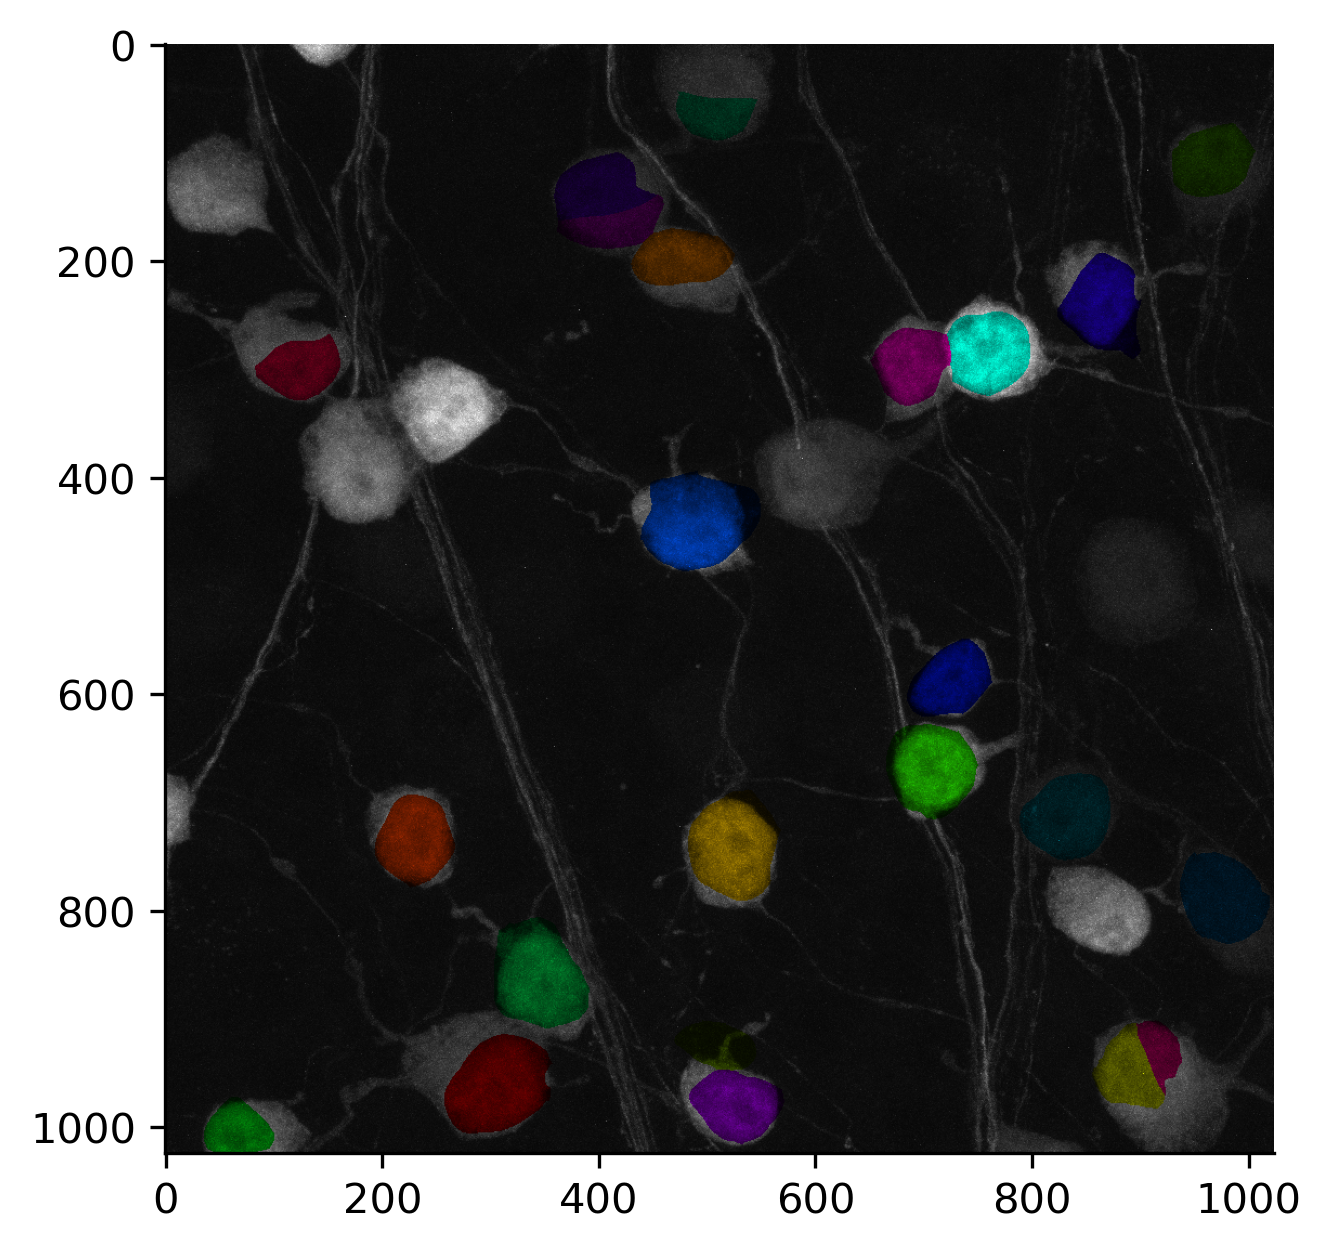

In [130]:
overlay = plot.mask_overlay(max_proj(image[:, 1, :, :]),
                            extract_masks(DAPI_masks, np.array([i[0] for i in  eGFP_fluorescence_list])[np.array([i[1] for i in  eGFP_fluorescence_list]) > 10]))
plt.imshow(overlay)

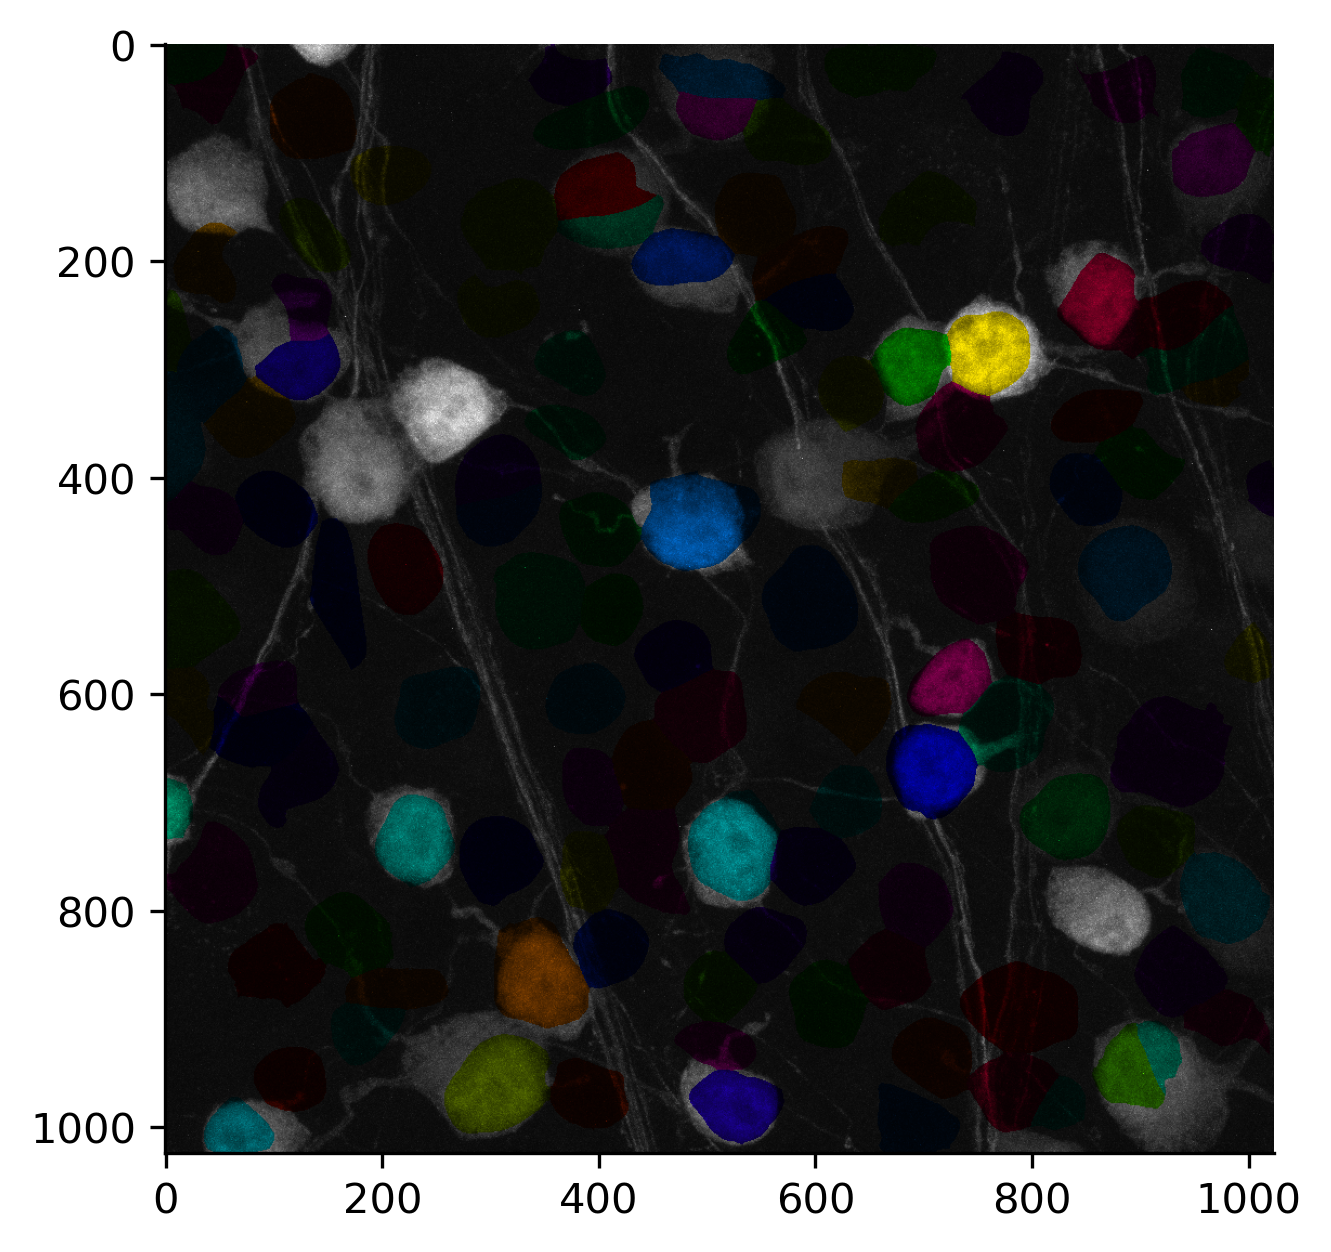

In [129]:
ov1 = plot.mask_overlay(max_proj(image[:,1, :, :]), DAPI_masks)
plt.imshow(ov1)

In [45]:
all_data

Y_vals  mask_id  Stain  \
0    [68334, 69990, 70355, 71791, 73158, 76089, 787...        1   DAPI   
1    [8962, 9175, 9418, 9516, 9838, 11164, 12055, 1...        1   eGFP   
2    [43102, 51037, 60108, 81220, 96703, 153469, 18...        1    WGA   
3    [3389, 4652, 5505, 7342, 8614, 12541, 15232, 1...        1  GluT1   
4    [64138, 64740, 65872, 68936, 69051, 73840, 770...        2   DAPI   
..                                                 ...      ...    ...   
443  [2011, 2342, 2974, 3418, 4533, 6674, 7899, 104...      117  GluT1   
444  [39252, 39600, 40803, 41129, 42950, 44844, 452...      118   DAPI   
445  [8210, 8697, 9429, 9836, 11106, 12786, 13708, ...      118   eGFP   
446  [18887, 20796, 24823, 27904, 37939, 55322, 647...      118    WGA   
447  [1106, 1303, 1813, 2332, 3049, 4152, 4675, 617...      118  GluT1   

                                                X_vals  \
0    [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
1    [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
2    [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
3    [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
4    [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
..                                                 ...   
443  [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
444  [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
445  [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
446  [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   
447  [0.0, 0.15, 0.3, 0.44999999999999996, 0.6, 0.7...   

                        file_name  DJID Eye  unid  in_rip  
0    3203R_GLUT1_647_WGA_594_0002  3203   R     0   False  
1    3203R_GLUT1_647_WGA_594_0002  3203   R     0   False  
2    3203R_GLUT1_647_WGA_594_0002  3203   R     0   False  
3    3203R_GLUT1_647_WGA_594_0002  3203   R     0   False  
4    3203R_GLUT1_647_WGA_594_0002  3203   R     1   False  
..                            ...   ...  ..   ...     ...  
443  3203R_GLUT1_647_WGA_594_0002  3203   R   110   False  
444  3203R_GLUT1_647_WGA_594_0002  3203   R   111   False  
445  3203R_GLUT1_647_WGA_594_0002  3203   R   111   False  
446  3203R_GLUT1_647_WGA_594_0002  3203   R   111   False  
447  3203R_GLUT1_647_WGA_594_0002  3203   R   111   False  

[448 rows x 9 columns]

/Users/raphaeltinio/Lab Analysis MAC/ImageAnalysis/Tusc5ImageUtils.py:739: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_cell['Stain'] = single_cell['Stain'].apply(lambda x: 'GluT1' if x == 'GluT1' else x)


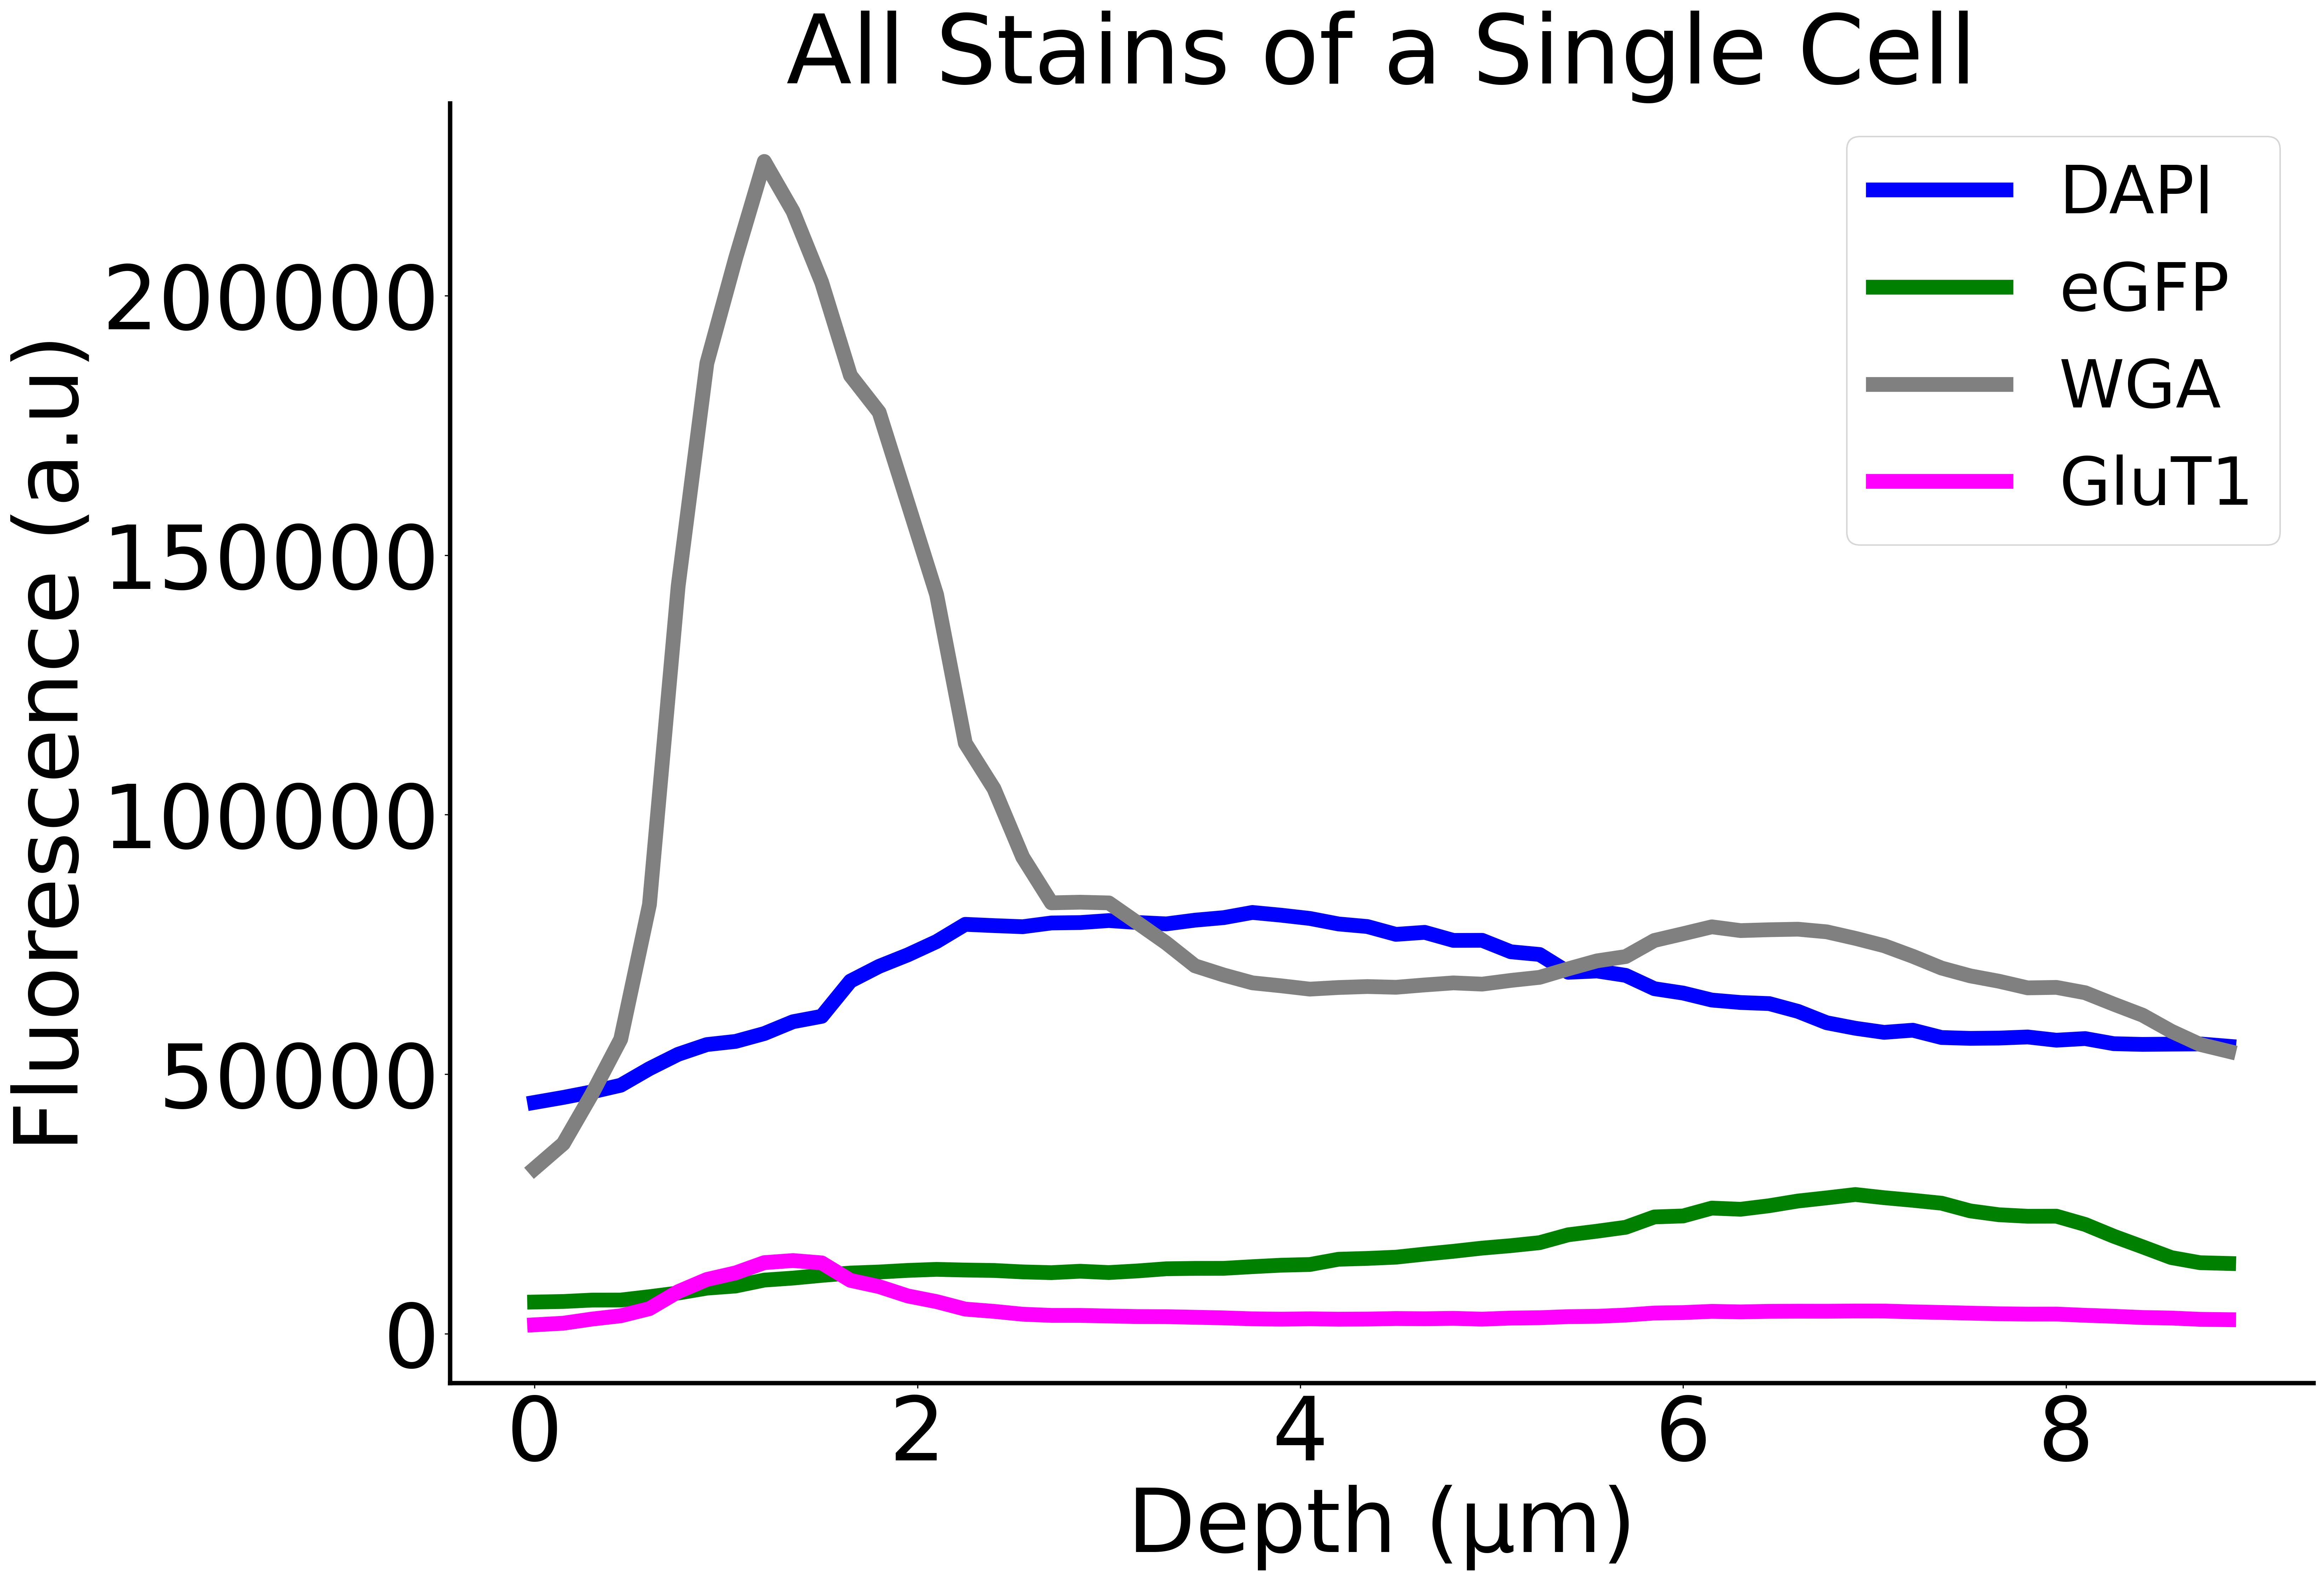

In [38]:
from scipy.signal import find_peaks

single_cell = all_data.query('unid == 45')
plot_single_cell(single_cell)